In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import string
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split

In [3]:
SOS_token = 0
EOS_token = 1


class Data:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
MAX_LENGTH = 30
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [5]:
def prepareData(input_data_path, target_data_path, num_samples=10000):
    with  open(input_data_path, 'r', encoding='utf-8') as f:
        input_lines = f.read().split('\n')  # 行ごとのリストに
    with open(target_data_path, 'r', encoding='utf-8') as f:
        target_lines = f.read().split('\n')
    min_samples = min(num_samples, min(len(input_lines)-1, len(target_lines)-1))
    pairs = [[i,t]for (i,t) in zip(input_lines[:min_samples],target_lines[:min_samples])]
    pairs.append(input_lines)
    pairs.append(target_lines)
    encoder_data = Data()
    decoder_data = Data()
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        encoder_data.addSentence(pair[0])
        decoder_data.addSentence(pair[1])
    print("Counted words:")
    print('encoder_data:{}'.format(encoder_data.n_words))
    print('decoder_data:{}'.format(decoder_data.n_words))

    return encoder_data, decoder_data, pairs

In [6]:
input_data_path = "./data/text/processed/merged_normal.txt"
target_data_path = "./data/text/processed/merged_normal.txt"
encoder_data, decoder_data, pairs = prepareData(input_data_path, target_data_path, 30000000)
print(len(pairs))
print(random.choice(pairs))

Trimmed to 1094030 sentence pairs
Counting words...
Counted words:
encoder_data:121095
decoder_data:121095
1094030
['しかし  、  泣い  た  の  は  この  時  だけ  。  ', 'しかし  、  泣い  た  の  は  この  時  だけ  。  ']


In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
def indexesFromSentence(data, sentence):
    return [data.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(data, sentence):
    indexes = indexesFromSentence(data, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(encoder_data, pair[0])
    target_tensor = tensorFromSentence(decoder_data, pair[1])
    return (input_tensor, target_tensor)

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [14]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
plt.style.use('ggplot')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(encoder_data, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(decoder_data.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 2s (- 0m 24s) (10 10%) 8.7539
0m 4s (- 0m 17s) (20 20%) 4.3407
0m 7s (- 0m 16s) (30 30%) 6.5957
0m 9s (- 0m 13s) (40 40%) 5.0873
0m 10s (- 0m 10s) (50 50%) 3.8202
0m 12s (- 0m 8s) (60 60%) 3.7331
0m 14s (- 0m 6s) (70 70%) 3.6067
0m 16s (- 0m 4s) (80 80%) 4.7263
0m 18s (- 0m 2s) (90 90%) 3.8791
0m 21s (- 0m 0s) (100 100%) 4.2340
>上方  の  和  事  狂言  の  代表  作  で  ある  。
=上方  の  和  事  狂言  の  代表  作  で  ある  。
<                 。

>「  こんな  日  も  ある  …  …  」
=「  こんな  日  も  ある  …  …  」
<                 。

>その  ９  ０  ％  余  が  個人  破産  で  ある  。
=その  ９  ０  ％  余  が  個人  破産  で  ある  。
<                。

>でも  、  失わ  れ  た  人生  は  戻ら  ない  。
=でも  、  失わ  れ  た  人生  は  戻ら  ない  。
<                。

>まさに  糖尿  病  は  自分  自身  な  の  です  。
=まさに  糖尿  病  は  自分  自身  な  の  です  。
<                 。

>喪主  は  妻  弘子  さん  。
=喪主  は  妻  弘子  さん  。
<                。

>自分  の  時間  も  持てる  よう  に  なっ  た  。
=自分  の  時間  も  持てる  よう  に  なっ  た  。
<                。

>でも  、  本当に  知り  たい  こと  が  どれ  だけ  、  と  も  思う  。
=でも  、  本当に  知り

<Figure size 432x288 with 0 Axes>

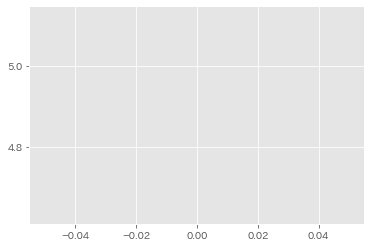

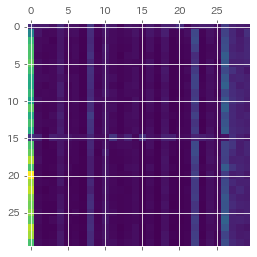

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(encoder_data.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, decoder_data.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 1000, print_every=10)

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "だが 「 市場 の 論理 」 万能 の グローバル 化 は どう か 。")
plt.matshow(attentions.numpy())

In [18]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [19]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input =だが 「 市場 の 論理 」 万能 の グローバル 化 は どう か 。
output =              。


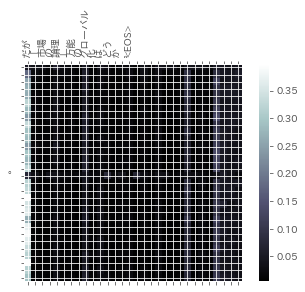

In [20]:
evaluateAndShowAttention("だが 「 市場 の 論理 」 万能 の グローバル 化 は どう か 。")